Lab done by
Saaketh, Rayaan, Vedant, Elias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential

In [2]:
# https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", header=None)
data = data[[0,5]]
data.columns = ["sentiment", "text"]

data["sentiment"] = data["sentiment"].replace(4, 1)

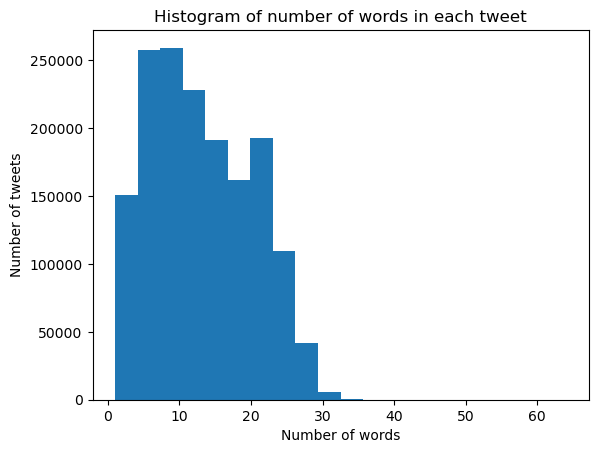

In [3]:
# Calculating number of words in each tweet:
data["word_count"] = data["text"].apply(lambda x: len(x.split()))
# plot histogram of number of words:
plt.hist(data["word_count"], bins=20)
plt.title("Histogram of number of words in each tweet")
plt.xlabel("Number of words")
plt.ylabel("Number of tweets")
data.drop("word_count", axis=1, inplace=True)

Due to twitter forcably limiting the number of characters, the number of words in each tweet are fairly constrained to under 30 words per tweet. For this reason we find it appropriate to use 30 word fixed length sequcnes for our models.

In [4]:
data.sentiment.value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

## Metrics
#### Accuracy:

Because the dataset is balanced, accuracy is an appropriate metric to use on our dataset. Our models will potentially be used to measure sentiment regarding certain topics on twitter and accuracy is a good measure to gauge the classification performance for that task. Another reason we are using accuracy is because we care equally about true positive and true negative with respect to false positives and false negatives, meaning accuracy is an appropriate metric. Additionally, this is the most used metric for senitment analysis tasks generally, making it appropriate for us, 


## Splitting:

We will use a standard 80-20 train test split. We have enough data, 1.6M tweets split evently amoung two classes is enough data to train and evaluate with.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["sentiment"], test_size=0.2, random_state=42)

## Creating Embedding Layer:

We used the tokenizer from keras to tokenize the individual words and then we searched through the pre trained 200 dimensional Twitter Glove embeddings to find the matching words from our tokenization process and and the mebedddings. Wethen used these matching words' embeddings to create our embedding layer, which we used for all the remaining models (keeping them as untrainable parametters). 

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % (len(word_index)))

Found 594848 unique tokens.


In [7]:
%%time
EMBED_SIZE = 200
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('glove.twitter.27B.200d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 1193514 word vectors.
Embedding Shape: (594849, 200) 
 Total words found: 121078 
 Percentage: 20.35440927025178
CPU times: user 38.4 s, sys: 1.34 s, total: 39.8 s
Wall time: 39.9 s


In [8]:
X_train = pad_sequences(X_train_sequences, maxlen=30)
X_test = pad_sequences(X_test_sequences, maxlen=30)

In [9]:

MAX_ART_LEN = 30

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

## Modeling:

In [10]:
def plot_history(history):
    # plot history of the model:
    fig = plt.figure(figsize=(10, 8))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validate')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')

In [11]:
rnn1 = Sequential()
rnn1.add(embedding_layer)
rnn1.add(LSTM(100))
rnn1.add(Dense(1, activation='sigmoid'))
rnn1.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
rnn1.summary()

2022-12-13 21:50:16.544686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 21:50:17.210342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30971 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 200)           118969800 
                                                                 
 lstm (LSTM)                 (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 119,090,301
Trainable params: 120,501
Non-trainable params: 118,969,800
_________________________________________________________________


In [12]:
history_rnn_1 = rnn1.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=2048)

Epoch 1/20


2022-12-13 21:50:20.107366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-13 21:50:21.999464: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2ab4c9d5e000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-13 21:50:21.999500: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-12-13 21:50:22.004289: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-13 21:50:22.289380: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - 11s 10ms/step - loss: 0.4548 - accuracy: 0.7840 - val_loss: 0.4240 - val_accuracy: 0.8027
Epoch 2/20
625/625 [==============================] - 6s 9ms/step - loss: 0.4130 - accuracy: 0.8095 - val_loss: 0.4057 - val_accuracy: 0.8134
Epoch 3/20
625/625 [==============================] - 6s 9ms/step - loss: 0.3973 - accuracy: 0.8185 - val_loss: 0.3966 - val_accuracy: 0.8182
Epoch 4/20
625/625 [==============================] - 6s 9ms/step - loss: 0.3875 - accuracy: 0.8240 - val_loss: 0.3914 - val_accuracy: 0.8216
Epoch 5/20
625/625 [==============================] - 6s 9ms/step - loss: 0.3799 - accuracy: 0.8282 - val_loss: 0.3869 - val_accuracy: 0.8239
Epoch 6/20
625/625 [==============================] - 6s 9ms/step - loss: 0.3739 - accuracy: 0.8312 - val_loss: 0.3852 - val_accuracy: 0.8255
Epoch 7/20
625/625 [==============================] - 6s 9ms/step - loss: 0.3687 - accuracy: 0.8341 - val_loss: 0.3811 - val_accuracy: 0.8272
Epoch 8/20
625/

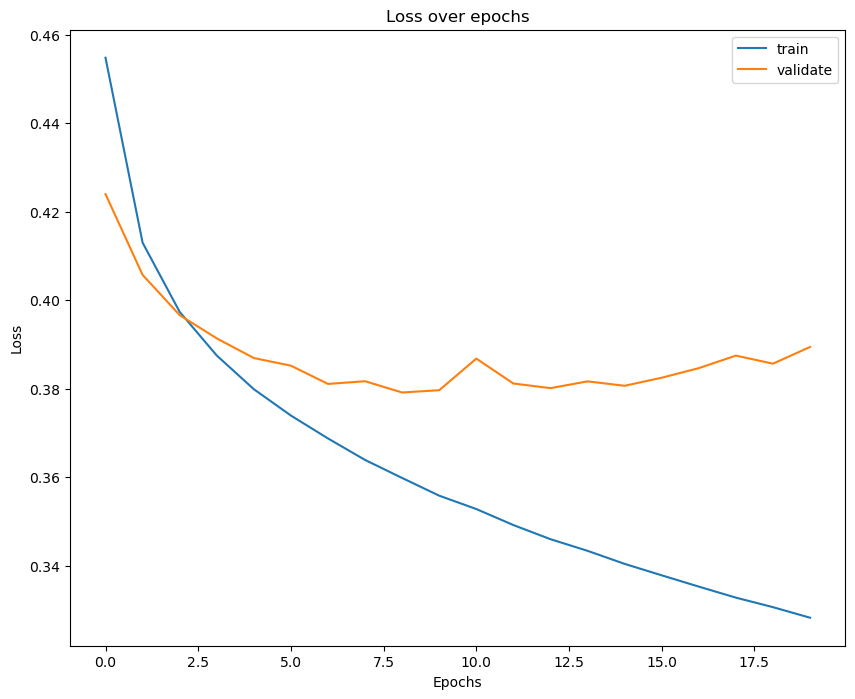

In [13]:
plot_history(history_rnn_1)

Our first RNN model managed to converge at around 12 epochs and got 82% on the validation set. The model also started to overfit as seen by the diverging training and testing loss. 

In [37]:
rnn2 = Sequential()
rnn2.add(embedding_layer)
rnn2.add(LSTM(100, dropout=0.2, recurrent_dropout = 0.2))
rnn2.add(Dense(1, activation='sigmoid'))
rnn2.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
rnn2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  118969800 
                                                                 
 lstm_3 (LSTM)               (None, 100)               120400    
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 119,090,301
Trainable params: 120,501
Non-trainable params: 118,969,800
_________________________________________________________________


In [38]:
history_rnn_2 = rnn2.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=2048)

Epoch 1/30
625/625 [==============================] - 27s 41ms/step - loss: 0.4669 - accuracy: 0.7762 - val_loss: 0.4269 - val_accuracy: 0.8015
Epoch 2/30
625/625 [==============================] - 26s 41ms/step - loss: 0.4268 - accuracy: 0.8012 - val_loss: 0.4125 - val_accuracy: 0.8097
Epoch 3/30
625/625 [==============================] - 26s 41ms/step - loss: 0.4141 - accuracy: 0.8085 - val_loss: 0.4024 - val_accuracy: 0.8157
Epoch 4/30
625/625 [==============================] - 25s 41ms/step - loss: 0.4052 - accuracy: 0.8140 - val_loss: 0.3990 - val_accuracy: 0.8171
Epoch 5/30
625/625 [==============================] - 25s 41ms/step - loss: 0.3993 - accuracy: 0.8174 - val_loss: 0.3913 - val_accuracy: 0.8220
Epoch 6/30
625/625 [==============================] - 26s 41ms/step - loss: 0.3945 - accuracy: 0.8199 - val_loss: 0.3897 - val_accuracy: 0.8221
Epoch 7/30
625/625 [==============================] - 25s 40ms/step - loss: 0.3904 - accuracy: 0.8223 - val_loss: 0.3845 - val_accuracy:

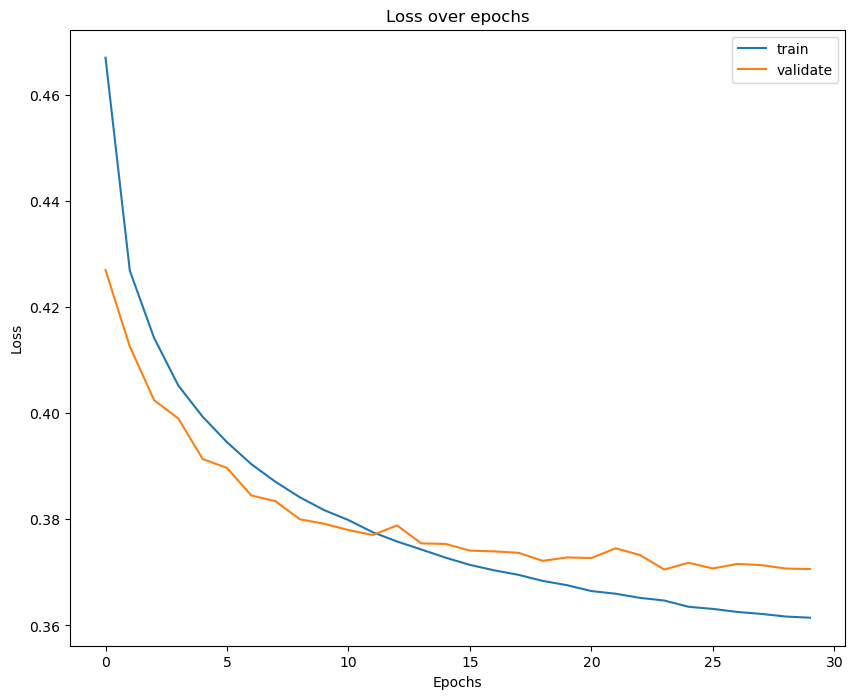

In [40]:
plot_history(history_rnn_2)

The dropout helps with overfitting, and the model manages to converge at 25 epochs, and achieves a validation accuracy of 83.4%. 

In [45]:
y_pred_rnn1 = rnn1.predict(X_test)
y_pred_rnn2 = rnn2.predict(X_test)

y_pred_rnn1 = np.round(y_pred_rnn1.reshape(-1))
y_pred_rnn2 = np.round(y_pred_rnn2.reshape(-1))

y_pred_rnn1_correct = np.sum((y_pred_rnn1 == y_test) & (y_pred_rnn2 != y_test))
y_pred_rnn2_correct = np.sum((y_pred_rnn2 == y_test) & (y_pred_rnn1 != y_test))

critical_value = (y_pred_rnn1_correct + y_pred_rnn2_correct)**2 / (y_pred_rnn1_correct + y_pred_rnn2_correct)
from scipy.stats import chi2
import math

1 - chi2.cdf(math.sqrt(critical_value), 1)

10000/10000 [==============================] - 87s 9ms/step


0.0

From the Mcnemar test, we can safely reject the null hypothesis that the two RNN's are the same, and conclude they are statistically significantly different. 

## CNNs:

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding

EMBED_SIZE = 200 #embedding size
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 30

embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(256, 3, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)
x = Dropout(0.15)(x)
x = Conv1D(256, 3, activation='relu',
           kernel_initializer='he_uniform')(x)


x = Dropout(0.2)(x)
x = Conv1D(256, 3, activation='relu',
           kernel_initializer='he_uniform')(x)

x = MaxPooling1D(24)(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)
opt = keras.optimizers.Nadam()
cnn1 = Model(sequence_input, preds)
cnn1.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

print(cnn1.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       multiple                  118969800 
                                                                 
 conv1d_3 (Conv1D)           (None, 28, 256)           153856    
                                                                 
 dropout_6 (Dropout)         (None, 28, 256)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 26, 256)           196864    
                                                                 
 dropout_7 (Dropout)         (None, 26, 256)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 24, 256)           1968

In [26]:
cnn_hist = cnn1.fit(X_train, y_train, validation_data=(X_test, y_test),
epochs=20, batch_size=2048)

Epoch 1/20
625/625 [==============================] - 20s 29ms/step - loss: 0.4766 - acc: 0.7697 - val_loss: 0.4252 - val_acc: 0.8047
Epoch 2/20
625/625 [==============================] - 18s 29ms/step - loss: 0.4183 - acc: 0.8071 - val_loss: 0.4067 - val_acc: 0.8140
Epoch 3/20
625/625 [==============================] - 18s 29ms/step - loss: 0.4018 - acc: 0.8163 - val_loss: 0.3974 - val_acc: 0.8193
Epoch 4/20
625/625 [==============================] - 18s 29ms/step - loss: 0.3917 - acc: 0.8220 - val_loss: 0.3931 - val_acc: 0.8225
Epoch 5/20
625/625 [==============================] - 18s 29ms/step - loss: 0.3835 - acc: 0.8265 - val_loss: 0.3871 - val_acc: 0.8249
Epoch 6/20
625/625 [==============================] - 18s 29ms/step - loss: 0.3772 - acc: 0.8297 - val_loss: 0.3856 - val_acc: 0.8256
Epoch 7/20
625/625 [==============================] - 18s 29ms/step - loss: 0.3718 - acc: 0.8328 - val_loss: 0.3855 - val_acc: 0.8271
Epoch 8/20
625/625 [==============================] - 18s 29ms

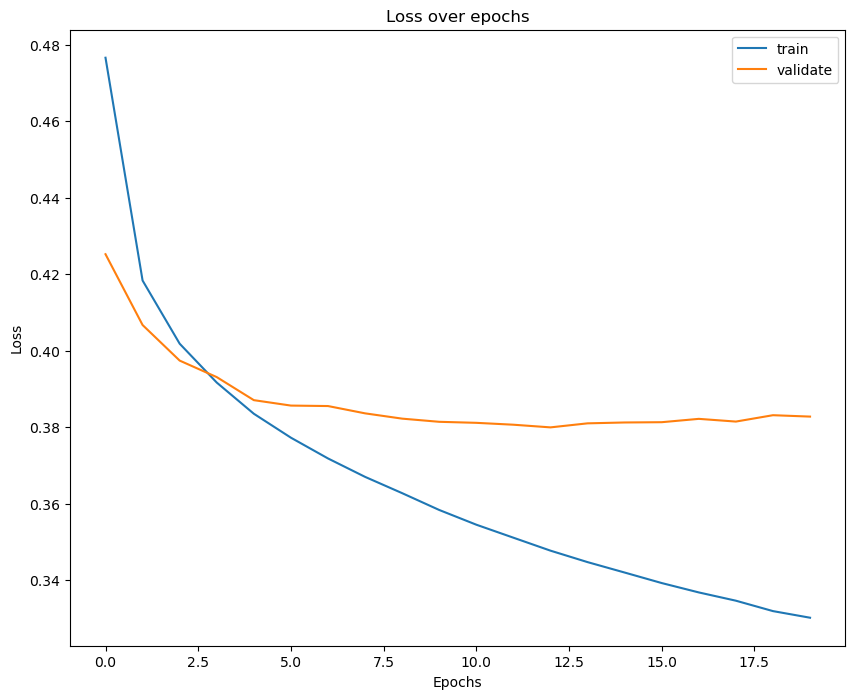

In [27]:
plot_history(cnn_hist)

The model manages to converge at 7ish epochs, as seen by the relatively flat validation loss. 

Let's see if we can get better results if we transform the sequence into a 2x15 dimensional array, such that we can use 2D convolutions, the idea here is that this forces the convolutions to relate close words in the sequence, as well as words in the opposite half of the sequence.

In [28]:
x2d = X_train.reshape(1280000, 15 , 2)
x2d.shape

(1280000, 15, 2)

In [29]:
X_train.shape

(1280000, 30)

In [30]:
x2d_test = X_test.reshape(320000, 15 , 2)
x2d_test.shape

(320000, 15, 2)

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAvgPool2D
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding



EMBED_SIZE = 200 #embedding size
sequence_input = Input(shape=(15,2), dtype='int32')
# starting size: 30

embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv2D(512, (1, 2), activation='relu',
           kernel_initializer='he_uniform', padding="same")(embedded_sequences)
x = Dropout(0.15)(x)
x = Conv2D(512, (2,2), activation='relu',
           kernel_initializer='he_uniform', padding="same")(x)


x = Dropout(0.2)(x)
x = Conv2D(512, (2, 5), activation='relu',
           kernel_initializer='he_uniform', padding="same")(x)
x = GlobalAvgPool2D()(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)
opt = keras.optimizers.Nadam()
cnn2 = Model(sequence_input, preds)
cnn2.compile(loss='mse',
              optimizer=opt,
              metrics=['acc'])

print(cnn2.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15, 2)]           0         
                                                                 
 embedding (Embedding)       multiple                  118969800 
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 2, 512)        205312    
                                                                 
 dropout_9 (Dropout)         (None, 15, 2, 512)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 15, 2, 512)        1049088   
                                                                 
 dropout_10 (Dropout)        (None, 15, 2, 512)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 15, 2, 512)        2621

In [32]:
cnn2_hist = cnn2.fit(x2d, y_train, validation_data=(x2d_test, y_test),
epochs=15, batch_size=2048)

Epoch 1/15


2022-12-13 22:07:07.404303: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 93s 147ms/step - loss: 0.1484 - acc: 0.7837 - val_loss: 0.1310 - val_acc: 0.8130
Epoch 2/15
625/625 [==============================] - 91s 146ms/step - loss: 0.1289 - acc: 0.8166 - val_loss: 0.1258 - val_acc: 0.8211
Epoch 3/15
625/625 [==============================] - 91s 146ms/step - loss: 0.1230 - acc: 0.8264 - val_loss: 0.1234 - val_acc: 0.8250
Epoch 4/15
625/625 [==============================] - 91s 146ms/step - loss: 0.1185 - acc: 0.8337 - val_loss: 0.1216 - val_acc: 0.8276
Epoch 5/15
625/625 [==============================] - 91s 146ms/step - loss: 0.1149 - acc: 0.8396 - val_loss: 0.1205 - val_acc: 0.8295
Epoch 6/15
625/625 [==============================] - 91s 146ms/step - loss: 0.1115 - acc: 0.8451 - val_loss: 0.1204 - val_acc: 0.8300
Epoch 7/15
625/625 [==============================] - 91s 146ms/step - loss: 0.1084 - acc: 0.8503 - val_loss: 0.1205 - val_acc: 0.8296
Epoch 8/15
625/625 [==============================] - 91s 146ms/st

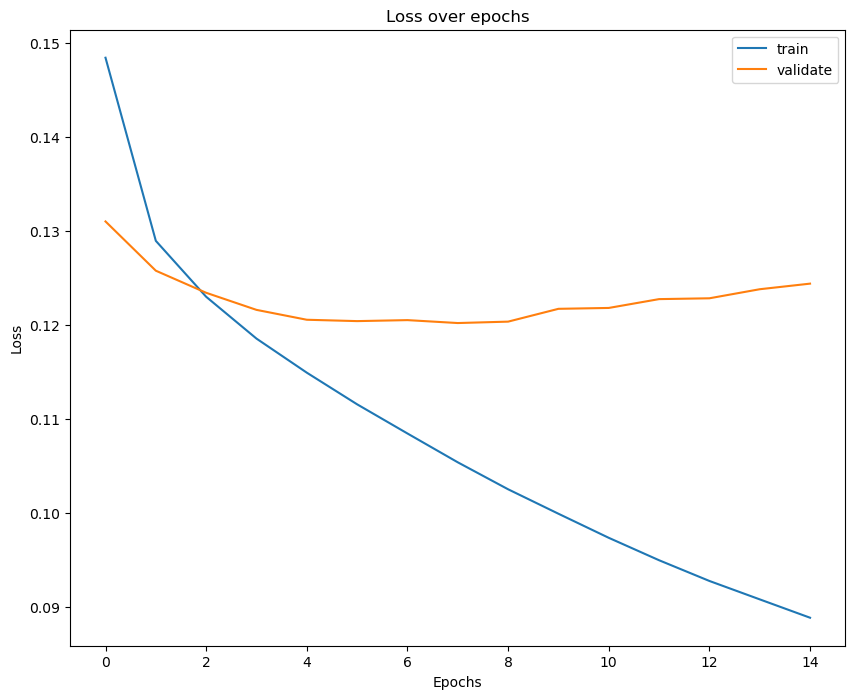

In [33]:
plot_history(cnn2_hist)

The model manages to converge at around 8 epochs, and actually gets slightly worse thereafter, indicating some overfitting. This model managed to peak at over 83% accuracy, which was similar to the 2nd LSTM we created, and slightly better than the 1D convolutional model. 

In [42]:
y_pred_cnn1 = cnn1.predict(X_test)
y_pred_cnn2 = cnn2.predict(x2d_test)

y_pred_cnn1 = np.round(y_pred_cnn1.reshape(-1))
y_pred_cnn2 = np.round(y_pred_cnn2.reshape(-1))

y_pred_cnn1_correct = np.sum((y_pred_cnn1 == y_test) & (y_pred_cnn2 != y_test))
y_pred_cnn2_correct = np.sum((y_pred_cnn2 == y_test) & (y_pred_cnn1 != y_test))

critical_value = (y_pred_cnn1_correct + y_pred_cnn2_correct)**2 / (y_pred_cnn1_correct + y_pred_cnn2_correct)
from scipy.stats import chi2
import math

1 - chi2.cdf(math.sqrt(critical_value), 1)


10000/10000 [==============================] - 15s 1ms/step


0.0

From the Mcnemar Test, we can conclude safely that these models are not the same, thus rejecting thenull hypothesis and concluding that the two CNN's are, in fact, different. The 1st CNN acheived 82.8% Validation accuracy while the 2nd CNN acheived 82.92% validation accuracy.

### Comparing RNN2 to CNN2:

In [43]:
y_pred_rnn2 = rnn2.predict(X_test)
y_pred_cnn2 = cnn2.predict(x2d_test)

y_pred_rnn2 = np.round(y_pred_rnn2.reshape(-1))
y_pred_cnn2 = np.round(y_pred_cnn2.reshape(-1))

y_pred_rnn2_correct = np.sum((y_pred_rnn2 == y_test) & (y_pred_cnn2 != y_test))
y_pred_cnn2_correct = np.sum((y_pred_cnn2 == y_test) & (y_pred_rnn2 != y_test))

critical_value = (y_pred_rnn2_correct + y_pred_cnn2_correct)**2 / (y_pred_rnn2_correct + y_pred_cnn2_correct)
from scipy.stats import chi2
import math

1 - chi2.cdf(math.sqrt(critical_value), 1)

10000/10000 [==============================] - 15s 1ms/step


0.0

From the Mcenmar test resulting in a p-value of 0, we can safely conclude the models are statistically signifcantly different, and thus reject the null hypothesis. 

Based on our analysis, we conclude that the 2nd RNN is the best model, as it had the highest validation accuracy (83.4%), which was our metric of choice for sentiment analysis. 